In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [2]:
prices = pd.read_csv("binance_data/From_Paper/2023/1m/merged_From_Paper_closing_prices_OCT_NOV.csv", index_col=0, parse_dates=True)

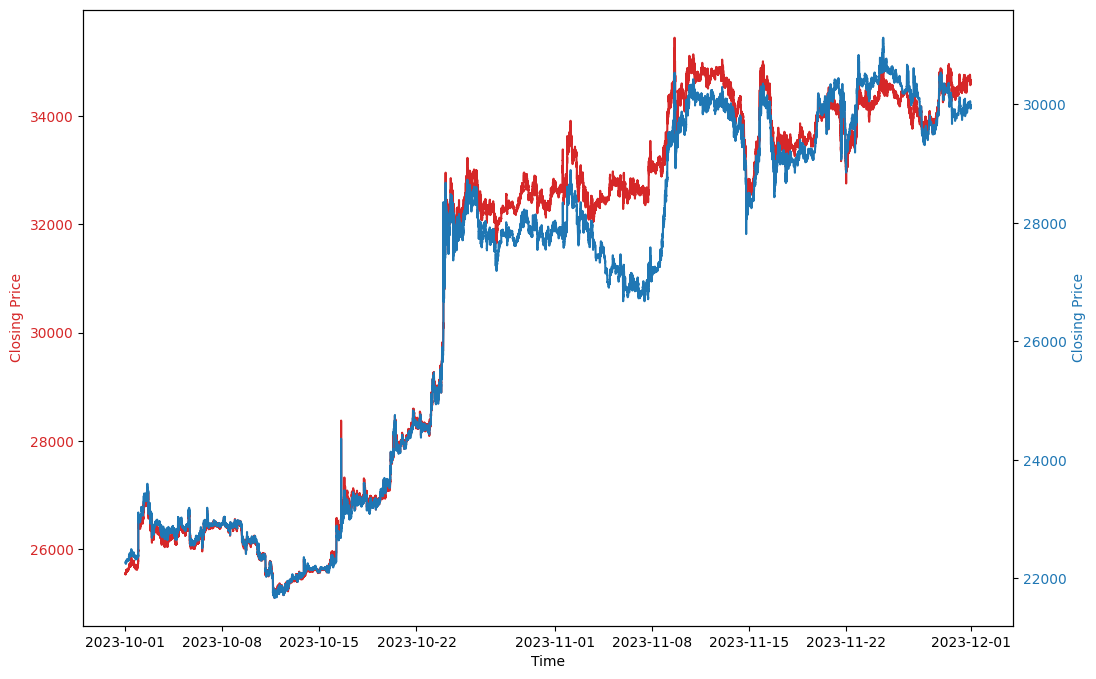

In [3]:
#Plot the closing prices of the merged data using different y axis


fig, ax1 = plt.subplots()

#Set size of the plot
fig.set_size_inches(12, 8)

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(prices.index, prices['BTCEUR_2023_1m'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Closing Price', color=color)
ax2.plot(prices.index, prices['BTCGBP_2023_1m'], color=color)
ax2.tick_params(axis='y', labelcolor=color)





In [4]:
#Calculate correlation matrix
correlation_matrix = prices.corr()
correlation_matrix

,BTCEUR_2023_1m,BTCGBP_2023_1m
BTCEUR_2023_1m,1.000000,0.989894
BTCGBP_2023_1m,0.989894,1.000000


# Applly funnel and test for cointegration
---

In [5]:

# # Pre-filter: Calculate correlation matrix and select pairs with high correlation
# corr_threshold = 0.8
# corr_matrix, high_corr_pairs = filter_high_correlation_pairs(prices, threshold=corr_threshold)
# print(f"\nPairs with correlation >= {corr_threshold}:")
# for pair in high_corr_pairs:
#     print(f"{pair[0]} & {pair[1]}: correlation = {pair[2]:.4f}")

# # Cointegration test
# cointegrated_pairs, pvalue_matrix, residuals_df = find_cointegrated_pairs(prices, high_corr_pairs,significance=0.05)
# #cointegrated_pairs, window_results = find_cointegrated_pairs_windows(prices, high_corr_pairs, significance=0.05, window_size=720, min_pass_fraction=0.5)


In [6]:
# cointegrated_pairs = [('BNB/USDT_2024_1h',
#   'BTC/USDT_2024_1h',
#   0.731393,
#   0.8501886494196308)]

In [7]:
# #If you suspect daily intraday patterns, using 24 lags is a natural choice: it checks each hour in a 24-hour cycle for dependence.
# #If your sample is large enough (covering many days/weeks), 24 lags is typically enough to detect standard intraday correlation
# analyze_residuals(residuals_df, lags = 24)

In [8]:
# cointegrated_pairs

# Test cointegration function on data designed to be cointegrated
---

In [9]:
# import numpy as np
# import pandas as pd

# def generate_cointegrated_data(
#     n=720,  # number of data points
#     alpha=5.0,
#     beta=1.5,
#     phi=0.8,
#     seed=42
# ):
#     """
#     Generate two cointegrated series: S1 (random walk) and S2 (linear function of S1 + stationary AR(1) noise).
    
#     Parameters:
#         n (int): Number of observations (e.g. 720 for ~1 month of hourly data).
#         alpha (float): Intercept term for S2.
#         beta (float): S2 coefficient for S1.
#         phi (float): AR(1) coefficient for the noise in S2 - beta*S1. Must be <1 in abs value for stationarity.
#         seed (int): Random seed for reproducibility.

#     Returns:
#         pd.DataFrame with columns ['S1', 'S2'] representing the two cointegrated time series.
#     """
#     rng = np.random.default_rng(seed)
    
#     # 1) Generate S1 as a random walk
#     #   S1_t = S1_{t-1} + e1_t
#     e1 = rng.normal(loc=0.0, scale=1.0, size=n)
#     S1 = np.cumsum(e1)  # cumsum => random walk
    
#     # 2) Generate a stationary AR(1) noise for the spread
#     #   ARnoise_t = phi * ARnoise_{t-1} + e2_t
#     e2 = rng.normal(loc=0.0, scale=1.0, size=n)
#     ARnoise = np.zeros(n)
#     for t in range(1, n):
#         ARnoise[t] = phi * ARnoise[t-1] + e2[t]
#     # ARnoise is stationary if |phi| < 1
    
#     # 3) Define S2 = alpha + beta*S1 + AR(1) noise
#     S2 = alpha + beta*S1 + ARnoise
    
#     # Put them in a DataFrame
#     df = pd.DataFrame({'S1': S1, 'S2': S2})
#     return df

# # Example usage
# if __name__ == "__main__":
#     df_cointegrated = generate_cointegrated_data(n=720)
#     print(df_cointegrated.head(10))


In [10]:
# # Suppose df has columns: 'S1', 'S2'
# alpha = 5.0
# beta = 1.5

# # Calculate the spread: S2 - (alpha + beta * S1)
# df_cointegrated['spread'] = df_cointegrated['S2'] - alpha - beta * df_cointegrated['S1']

# # Plot
# plt.figure(figsize=(10,6))
# plt.plot(df_cointegrated['spread'], label='Spread = S2 - alpha - beta*S1')
# plt.axhline(df_cointegrated['spread'].mean(), color='red', linestyle='--', label='Mean')
# plt.title('Spread Over Time')
# plt.legend()
# plt.show()


# Windows
---

### On data designed to be cointegrated

In [11]:
high_corr_pairs = []

In [12]:
# cointegrated_pairs, window_results = find_cointegrated_pairs_windows(df_cointegrated, high_corr_pairs, significance=0.05, window_size=240, min_pass_fraction=0.5)

In [13]:
# window_results

# Test cointegration on actual data
---

In [14]:
cointegrated_pairs, window_results = find_cointegrated_pairs_windows(prices, high_corr_pairs, significance=0.05, window_size=1440, min_pass_fraction=0.5)


Cointegrated pairs (across windows):
BTCEUR_2023_1m & BTCGBP_2023_1m: pass fraction=0.51, avg p-value=0.1793, correlation=0.0


In [15]:
# windows = split_price_series_into_windows(prices, window_size=1440)

# #For ICP/USDT_2024_1h', 'ADA/USDT_2024_1h
# plot_spread_in_windows('BTCEUR_2023_1m', 'BTCGBP_2023_1m', windows, window_results, significance=0.05) #These spreads look like they are standardised, but they are not. They are centered around 0 due to the inclusion of the intercept term in the cointegration test. The spread is still in the original units of the data.
# #plot_spread_in_windows('S1', 'S2', windows, window_results, significance=0.05)

# Trading simulation
---

* ## In-Sample Testing

In [16]:
if cointegrated_pairs:
        sym1, sym2, pass_fraction, avg_p_value,correlation = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (pass_fractioon: {pass_fraction:.4f},average_p_value: {avg_p_value:.4f} correlation: {correlation:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]
        
        # Compute the spread series and beta_series 
        spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size=1440)
        #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

        # Compute rolling z-score using the provided helper function.
        zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size = 1440)
        
        # Generate trading signals (positions) based on the spread's z-score
        positions_series, win_indexs, loss_indexs = backtest_pair_rolling(spread_series,zscore_series, entry_threshold=1.0, exit_threshold=0.1, stop_loss_threshold=2.0)
        
        #Simulate strategy performance
        #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)
        
        pnl, cum_pnl = simulate_true_strategy_rolling(S1, S2, positions_series, beta_series)
        


Testing strategy on pair: BTCEUR_2023_1m and BTCGBP_2023_1m (pass_fractioon: 0.5082,average_p_value: 0.1793 correlation: 0.0000)
Total trades closed: 3299 (Wins=1352, Losses=1947)
Win rate: 0.41


In [17]:
# spread_series_mean = spread_series.mean()

# plt.plot(spread_series)
# plt.axhline(spread_series_mean, color='r', linestyle='--')
# plt.title('Spread series')
# plt.show()


# #Get max true spread


In [18]:
# alpha_series_mean = alpha_series.mean()

# plt.plot(alpha_series)
# plt.axhline(alpha_series_mean, color='r', linestyle='--')
# plt.title('Alpha series')

# #Print smallest and largest values of alpha

# print(f"Smallest value of alpha: {alpha_series.min()}")
# print(f"Largest value of alpha: {alpha_series.max()}")
# print(f"Mean value of alpha: {alpha_series_mean}")

In [19]:
# #get index where z score was the highest

# zscore_series.idxmin()



In [20]:
daily_pnl_series, cum_pnl_series, cum_pnl_pct_series = simulate_strategy_pnl(S1, S2, positions_series, beta_series=beta_series, initial_capital=1000.0)

print(f"Total PnL: {cum_pnl_series[-1]:.2f} EUR")
print(f"Total PnL (%): {cum_pnl_pct_series[-1]:.2f}%")

Total PnL: 1125.27 EUR
Total PnL (%): 112.53%


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_98550/721721545.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total PnL: {cum_pnl_series[-1]:.2f} EUR")
/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_98550/721721545.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total PnL (%): {cum_pnl_pct_series[-1]:.2f}%")


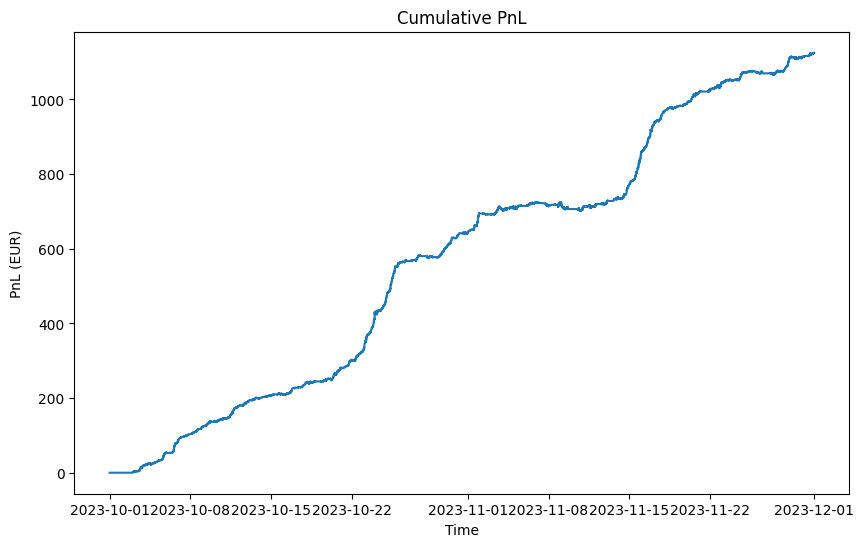

In [21]:
#Plot the cumulative PnL
plt.figure(figsize=(10,6))
plt.plot(cum_pnl_series)
plt.title('Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('PnL (EUR)')
plt.show()

Long Entries In Window: 3, Short Entries In Window: 0
Wins In Window: 2, Losses In Window: 1


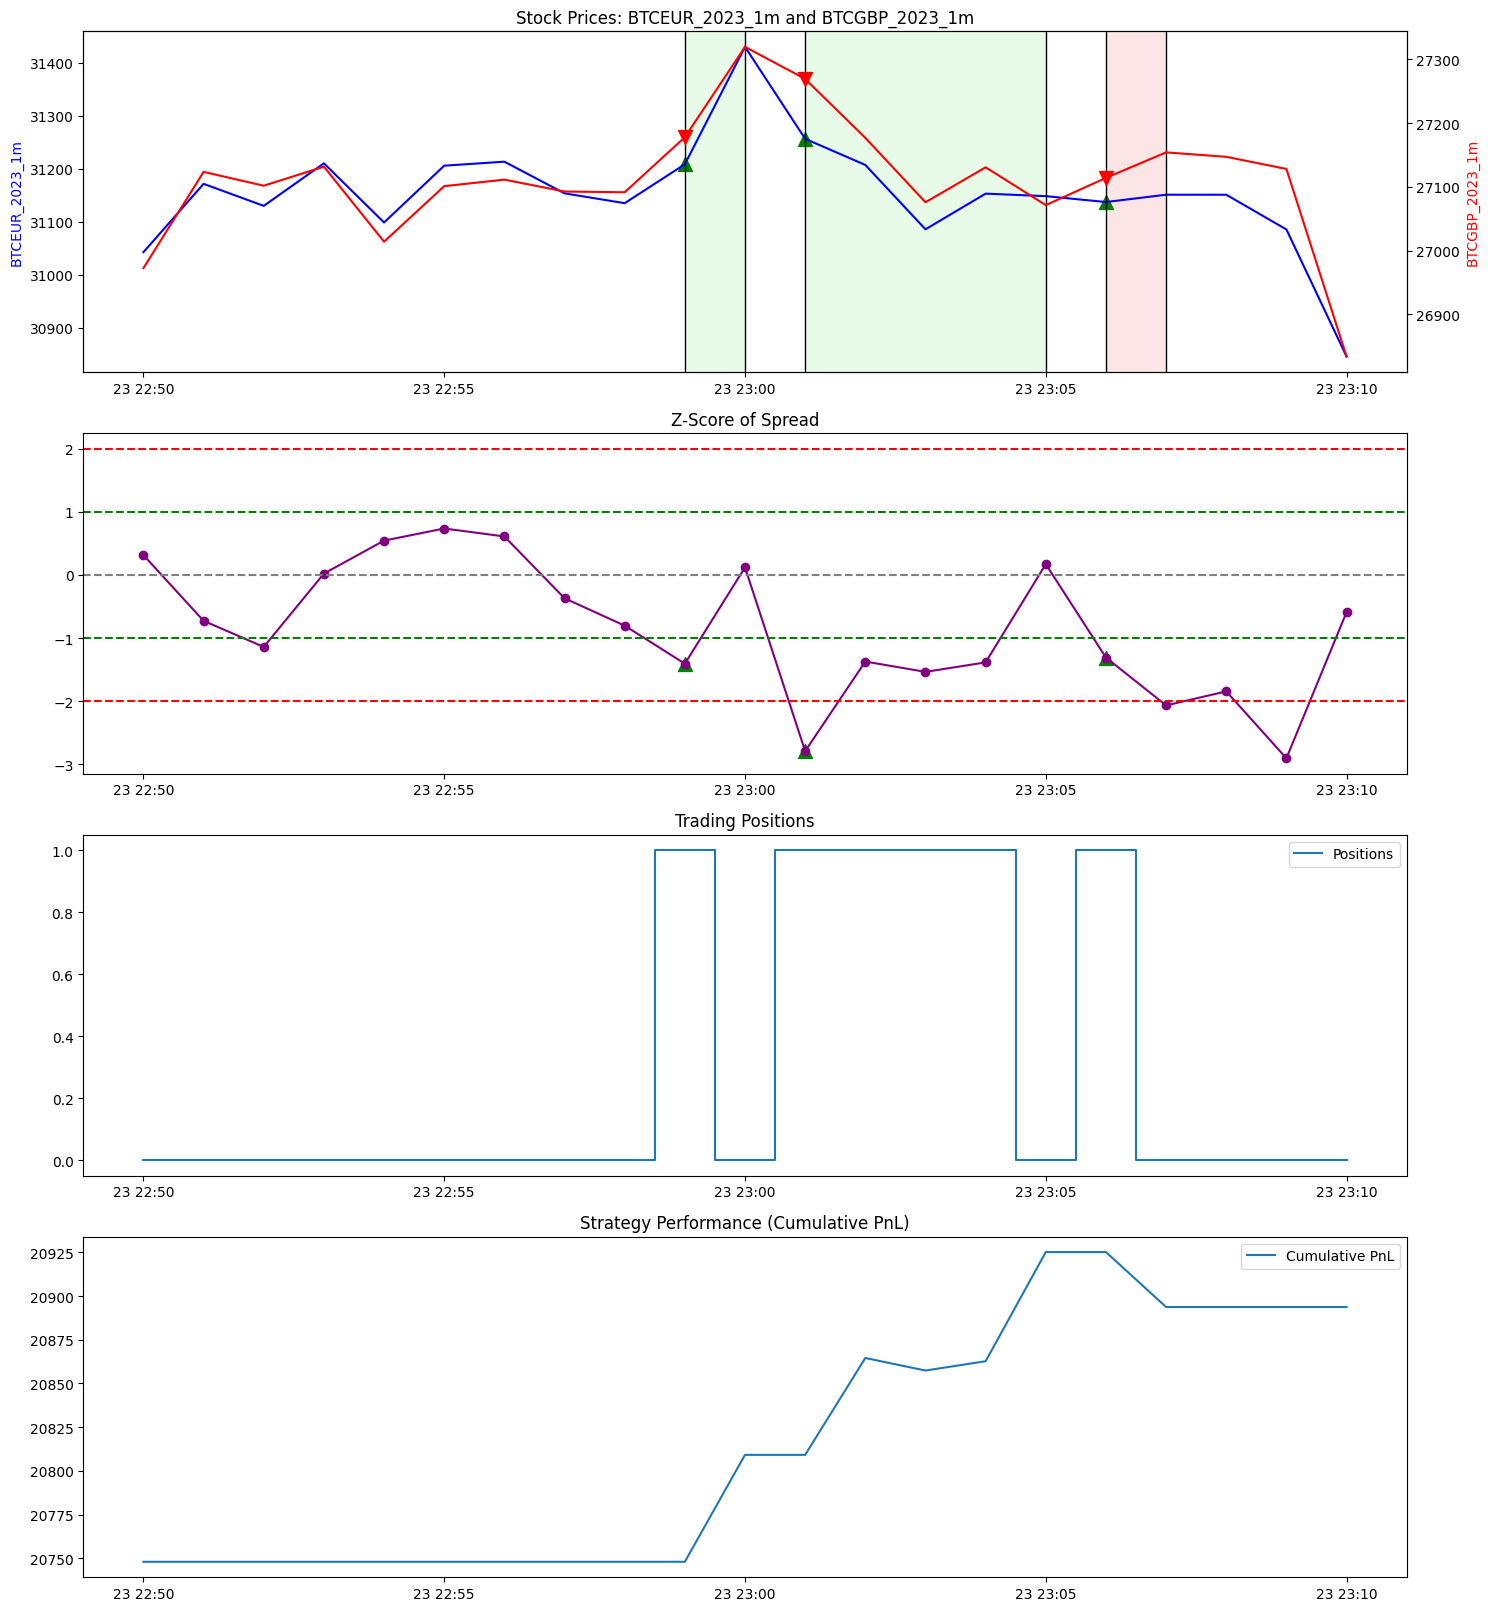

In [22]:
#Plot trading simulation
window_start = '2023-10-23 22:50:00'
window_end = '2023-10-23 23:10:00'

# window_start = '2023-10-22 22:43:00'
# window_end = '2023-10-23 22:43:00'

# window_start = None
# window_end = None

#NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES


plot_trading_simulation(S1, S2, sym1,sym2,zscore_series, positions_series, 
                        cum_pnl,win_indexs=win_indexs,loss_indexs=loss_indexs,
                        window_start=window_start, window_end=window_end)



In [23]:
# plt.plot(spread_series.loc[window_start:window_end])
# plt.title('Spread Over Time')
# plt.legend()

In [24]:
#zip S1 and S2 together
S1_window = S1.loc[window_start:window_end]
S2_window = S2.loc[window_start:window_end]

#2023-10-23 22:43:00   -20.599535
#compute spread

rolling_mean_window = rolling_mean.loc[window_start:window_end]

rolling_std_window = rolling_std.loc[window_start:window_end]

spread_series_window = spread_series.loc[window_start:window_end]

alpha_series_window = alpha_series.loc[window_start:window_end]

z_score_window = zscore_series.loc[window_start:window_end]

beta_series_window = beta_series.loc[window_start:window_end]

#Merge dataframes together

merged_df = pd.concat([S1_window,S2_window,spread_series_window,rolling_mean_window,rolling_std_window,alpha_series_window,z_score_window,beta_series_window],axis=1)

merged_df.columns = ['S1','S2','Spread','Rolling Mean','Rolling Std','Alpha','Z Score','Beta']

merged_df

,S1,S2,Spread,Rolling Mean,Rolling Std,Alpha,Z Score,Beta
timestamp,,,,,,,,
2023-10-23 22:50:00,31042.51,26972.64,27.681983,14.985897,40.438611,497.963980,0.313960,1.131401
2023-10-23 22:51:00,31171.54,27123.59,-14.380914,15.024520,40.424146,494.595179,-0.727423,1.131536
2023-10-23 22:52:00,31129.96,27101.92,-31.099194,15.015676,40.429189,499.106655,-1.140633,1.131357
2023-10-23 22:53:00,31210.31,27131.83,15.815214,14.969006,40.443614,503.729721,0.020923,1.131172
2023-10-23 22:54:00,31098.56,27014.00,36.910057,14.956304,40.440471,497.420246,0.542866,1.131422
2023-10-23 22:55:00,31205.90,27101.25,44.642541,14.946465,40.433399,485.457468,0.734444,1.131896
2023-10-23 22:56:00,31213.42,27111.46,39.559307,14.940131,40.428029,471.557694,0.608963,1.132447
2023-10-23 22:57:00,31153.61,27092.80,-0.012385,14.936495,40.425577,459.593127,-0.369788,1.132922
2023-10-23 22:58:00,31135.02,27091.67,-17.578349,14.897181,40.412557,455.624650,-0.803600,1.133078


Text(0.5, 1.0, 'Time series of S1 and S2 from window start to window end')

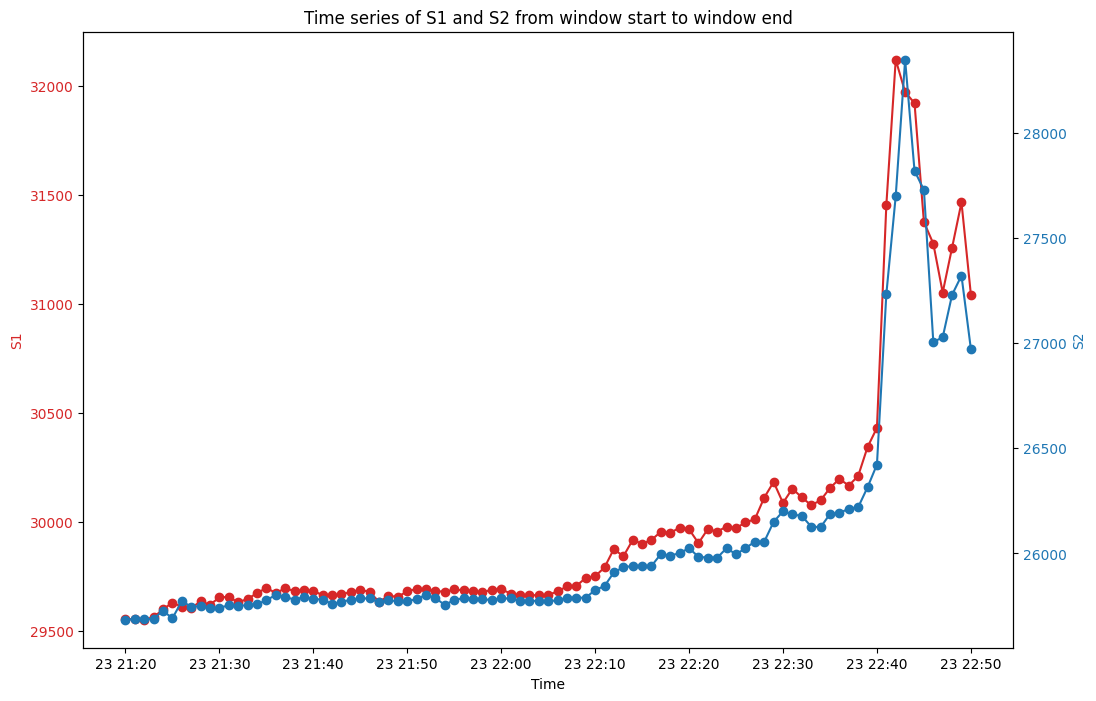

In [25]:
window_start = '2023-10-23 21:20:00'
window_end = '2023-10-23 22:50:00'

#Time of event: 2023-10-23 22:43:00	

S1_window = S1[window_start:window_end]
S2_window = S2[window_start:window_end]

#Plot time series from window start to window end on different y axis and show data points



fig, ax1 = plt.subplots()

#Set size of the plot
fig.set_size_inches(12, 8)

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('S1', color=color)
ax1.plot(S1_window, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'  
ax2.set_ylabel('S2', color=color)
ax2.plot(S2_window, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Time series of S1 and S2 from window start to window end')






# plt.plot(S1_window)
# plt.plot(S2_window)
# plt.title('Time series of S1 and S2 from window start to window end')
# plt.show()

In [26]:
# spre = 31971.76 - (-2.096653) - 1.151277 * 28349.60
# spre